# Introduction to Style Transfer
Style transfer is a novel application of convolutional neural networks that has nothing to do with predicting or classifying anything. The idea is to take two template images, one for "style" and one for "content", and combine the stylistic elements of one image with the content of the other image to create a new piece of art. 

The mechanism by which this is achieved is still through gradient descent, with a few new twists:

1. We are minimizing a new loss function, one that describes the difference of the network's output and the desired "style" and "content" of the two template images. 

2. Instead of updating kernel weights during gradient descent, we are updating the pixels of what is initially an image of white noise or perhaps the content template. 

The mystery in all of this is how we define the differences between style and content, and then how we mathematically extract them from an image. 

## Defining Content and Style
If you've studied how convolutional neural networks learn, you probably know that each convolutional layer is made up of a stack of filters (AKA kernels) that are applied to incoming data to extract features. As general features are extracted, specific detail begins to be stripped away by pooling layers. This is on purpose, and is what allows our network to generalize to unseen data. 

### Content
With the above in mind, we might guess that general "content" of an image is best encapsulated in later layers. Indeed, the authors of the original paper on style transfer chose to use the 10th of 16 convolutional layers to best represent an images content. It bears going over the network architecture they chose, which is VGG19.

VGG19 contains a total of 16 convolutional layers. These layers come in 5 stacks, where each stack contains either 2 or 4 conv layers each:

     Conv 1: 2 conv layers, depth of 64, followed by a pooling layer
     Conv 2: 2 conv layers, depth of 128, followed by a pooling layer
     C 3: 4 conv layers, depth of 256, followed by a pooling layer
     Stack 4: 4 conv layers, depth of 512, followed by a pooling layer
     Stack 5: 4 conv layers, depth of 512, followed by a pooling layer

Individual conv layers are identified with the notation $\textbf{conv}_{i,j}$, where $i$ represents the $i$th stack and $j$ is the $j$th layer with in that stack. Therefore, the 10th convolutinal layer would be $\textbf{conv}_{4, 2}$.

Functionally, getting content prepresentation is achieved by simply passing an image with the desired content through each layer of the VGG19 network, until we get to $\textbf{conv}_{4,2}$. The output of this layer becomes our "content ground truth", on which we base a loss function that describes the difference between a target image content and the content we desire. 

### Style

Style can be thought of as the general pattern of curves, lines and colors used in a given piece of art. Our goal, then, is to find a way to express those patterns numerically.

Recall that a single convolutional layer takes an image and runs it through $n$ filters. Each filter is designed (or trained) to pick up on a different pattern in the image. Determining "style" comes down to the idea of finding correlations between the patterns found by different filters. If you are familiar with how a standard correlation matrix is calculated, then you will quickly see that style is determined by a very similar, but simpler process. 

Imagine that we have a convolutional layer $l$ that has $n$ filters, outputing $n$ feature channels. Each output has height and width $h$ and $w$. This convolutional layer would give us a tensor with dimensions ($n, h, w$). Then:

1. Flatten each of $n$ feature from conv layer $l$ into a row vector.
2. Stack all the new row vectors so that you have a 2-d tensor/matrix we will call $S$.
3. Compute $G^l = SS^T$. 

This new matrix $G^l$ is the matrix that contains the style information found in convolutional layer $l$.

As with content, we will get a "ground truth" style by passing our style template image through the network and computing $G^l$ for each of several layers. This collection of matrices will then be used in a loss function that compares the style of a target image with the style we desire. 

In [102]:
import torch
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, transforms, models

import requests
from io import BytesIO
from PIL import Image
import cv2

import matplotlib.pyplot as plt
import numpy as np

In [103]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [148]:
def load_image(path, max_size=400, shape=None, gray=False):
    if 'http' in path:
        response = requests.get(path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(path).convert('RGB')
    
    
    if shape is not None:
        size = shape
    elif max(image.size) > max_size:
        size = max_size   
    else:
        size = max(image.size)
        
    if gray:
        image = image.convert('L')
        image = image.convert('RGB')
    
    in_transform = transforms.Compose([transforms.Resize(size),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.485, 0.456, 0.406), 
                                                                 (0.229, 0.224, 0.225))])
    
    return in_transform(image).unsqueeze(0)

In [149]:
def get_features(model, image):

    layers = {
        '0' : 'conv1_1',
        '5' : 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    
    features = {}
    
    x = image
    for name, layer in vgg._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    
    return features

In [150]:
# load in content and style image, and create target image
content = load_image('data/content/octopus.jpg', gray=True).to(device)
# Resize style to match content, makes code easier
style = load_image('data/style/clouds-19.jpg', shape=content.shape[-2:]).to(device)
# Target image on which gradient descent will be performed:
target = content.clone().requires_grad_(True).to(device)

In [151]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

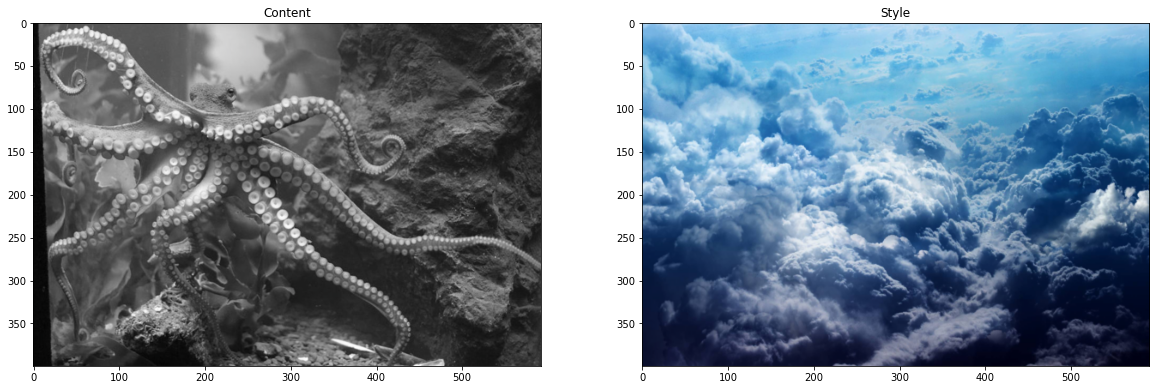

In [152]:
# display the content and style images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax1.set_title('Content')
ax2.set_title('Style');

In [153]:
def gramian(tensor):
    """
    Compute the gramian matrix of a single feature map
    """
    t = tensor.view(512, -1)
    return t @ t.T

def content_loss(c_features, t_features):
    """
    Compute mean squared error of all feature maps. 
    """
    loss = (t_features['conv4_2'] - c_features['conv4_2']) ** 2
    return torch.mean(loss)

def style_loss(s_grams, t_features, weights):
    """
    Compute style loss, i.e. the weighted sum of MSE of all layers. 
    """
    # for each style feature, get target and style gramians, compare
    loss = 0
    for layer in weights:
        _, d, h, w = s_features[layer].shape
        t_gram = gramian(t_features[layer])    
        
        layer_loss = torch.mean((t_gram - s_grams[layer]) ** 2) / (d * h * w)
        loss += layer_loss * weights[layer]
    
    return loss     

Total loss:  1422.57861328125


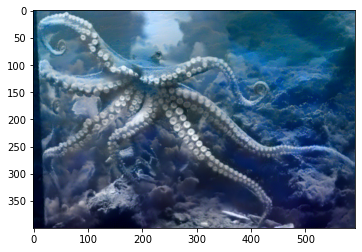

Total loss:  684.0732421875


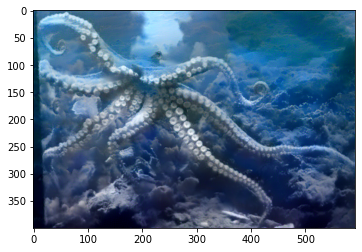

Total loss:  425.1241149902344


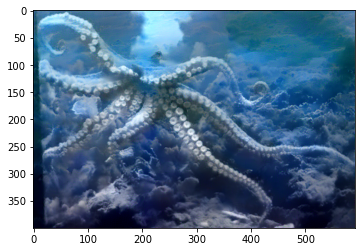

Total loss:  301.2106018066406


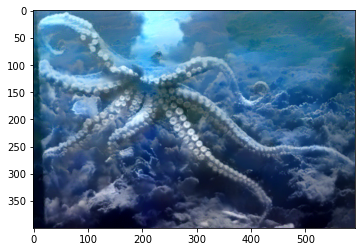

Total loss:  223.94097900390625


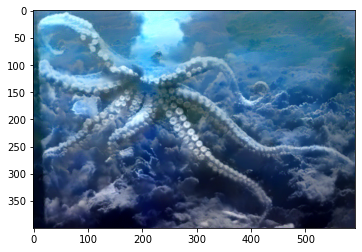

In [154]:
style_weights = {'conv1_1': .2,
                 'conv2_1': .2,
                 'conv3_1': .2,
                 'conv4_1': .2,
                 'conv5_1': .2}

show  = 1000
steps = 5000
c_weight = 1
s_weight = 1e4

s_features = get_features(vgg, style)
c_features  = get_features(vgg, content)
s_grams = {layer: gramian(features) for layer, features in s_features.items()}

opt = optim.Adam([target], lr=0.009)

for step in range(1, steps + 1):
    opt.zero_grad()
    
    t_features = get_features(vgg, target)
    c_loss = content_loss(c_features, t_features)
    s_loss = style_loss(s_grams, t_features, style_weights)
    
    total_loss = c_weight * c_loss + s_weight * s_loss
    total_loss.backward()
    opt.step()
    
    if step % show == 0:
            print('Total loss: ', total_loss.item())
            plt.imshow(im_convert(target))
            plt.show()

In [155]:
image = im_convert(target)
image = Image.fromarray((image*255).astype(np.uint8))

In [156]:
image.save('data/art/oct01.jpg')